In [1]:
import tensorflow as tf
import os


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
import cv2
import imghdr

In [4]:
folder_path = 'small_data'

In [5]:
import os
import cv2
import imghdr

def get_class_names(folder_path, valid_exts=['jpeg', 'png', 'jpg']):
    class_names = []
    for image_class in os.listdir(folder_path):
        class_names.append(image_class)
        class_path = os.path.join(folder_path, image_class)
        
        if os.path.isdir(class_path):
            for image in os.listdir(class_path):
                image_path = os.path.join(class_path, image)
                try:
                    img = cv2.imread(image_path)
                    if img is None:
                        os.remove(image_path)
                        continue
                    tip = imghdr.what(image_path)
                    if tip not in valid_exts:
                        os.remove(image_path)
                except Exception as e:
                    print(f"Issue with image {image_path}: {e}")
    
    return class_names


In [6]:
import numpy as np 
import matplotlib.pyplot as plt


In [7]:
data = tf.keras.utils.image_dataset_from_directory(folder_path)



Found 448 files belonging to 3 classes.


In [8]:
data_iterator = data.as_numpy_iterator()
batch = next(data_iterator)

In [9]:
images , labels = batch


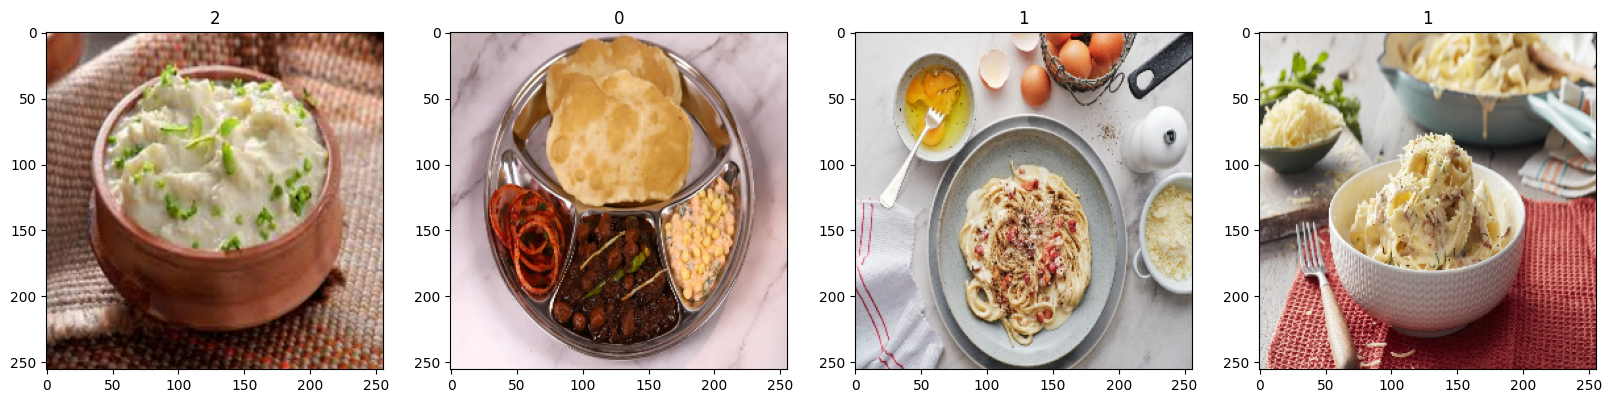

In [10]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [11]:
data = data.map(lambda x,y: (x/255, y))
data.as_numpy_iterator().next()

(array([[[[6.15686297e-01, 6.31372571e-01, 6.43137276e-01],
          [6.15686297e-01, 6.31372571e-01, 6.43137276e-01],
          [6.15686297e-01, 6.31372571e-01, 6.43137276e-01],
          ...,
          [5.90088844e-01, 5.90088844e-01, 5.97931981e-01],
          [5.88648915e-01, 5.88648915e-01, 5.96492052e-01],
          [5.88235319e-01, 5.88235319e-01, 5.96078455e-01]],
 
         [[6.15686297e-01, 6.31372571e-01, 6.43137276e-01],
          [6.15686297e-01, 6.31372571e-01, 6.43137276e-01],
          [6.15686297e-01, 6.31372571e-01, 6.43137276e-01],
          ...,
          [5.94348609e-01, 5.94348609e-01, 6.02191746e-01],
          [5.88887990e-01, 5.88887990e-01, 5.96731126e-01],
          [5.88235319e-01, 5.88235319e-01, 5.96078455e-01]],
 
         [[6.16850495e-01, 6.32536769e-01, 6.44301474e-01],
          [6.16850495e-01, 6.32536769e-01, 6.44301474e-01],
          [6.16850495e-01, 6.32536769e-01, 6.44301474e-01],
          ...,
          [6.09035611e-01, 6.09035611e-01, 6.1687

In [12]:
train_size = int(len(data)* 0.7)
val_size = int(len(data)* 0.2)
test_size = int(len(data)* 0.1)

In [14]:
from tensorflow.keras.utils import to_categorical
num_classes = len(get_class_names(folder_path))  
labels_one_hot = to_categorical(labels, num_classes=num_classes)
train_data = data.take(train_size)
val_data = data.skip(train_size).take(val_size)
test_data = data.skip(train_size + val_size).take(test_size)

def one_hot_encode(image, label):
    return image, tf.one_hot(label, depth=num_classes)
train_data = train_data.map(one_hot_encode)
val_data = val_data.map(one_hot_encode)
test_data = test_data.map(one_hot_encode)


In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.metrics import Precision , Recall
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout




In [16]:
model = Sequential(name='Image_classification_model')
model.add(Conv2D(64, (3, 3), 1, activation='relu', input_shape=(256, 256, 3), kernel_regularizer=l2(0.01)))
model.add(MaxPooling2D())
model.add(Dropout(0.2))
model.add(Conv2D(128, (3, 3), 1, activation='relu',kernel_regularizer=l2(0.01)))
model.add(MaxPooling2D())
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), 1, activation='relu',kernel_regularizer=l2(0.01)))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(256, activation='relu',kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))  

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
model.summary()

Model: "Image_classification_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 64)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 128)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 62, 

In [18]:
logdir = 'logs'
tensorboard_callbacks = tf.keras.callbacks.TensorBoard(log_dir= logdir)
hist = model.fit(train_data , epochs=20, validation_data=val_data, callbacks=[tensorboard_callbacks])

Epoch 1/20
9/9 [==============================] - 142s 15s/step - loss: 9.0319 - accuracy: 0.4097 - val_loss: 5.6320 - val_accuracy: 0.3594
Epoch 2/20
9/9 [==============================] - 132s 14s/step - loss: 5.2474 - accuracy: 0.4722 - val_loss: 4.8011 - val_accuracy: 0.5000
Epoch 3/20
9/9 [==============================] - 131s 14s/step - loss: 4.4244 - accuracy: 0.5000 - val_loss: 4.0784 - val_accuracy: 0.4844
Epoch 4/20
9/9 [==============================] - 116s 12s/step - loss: 3.7449 - accuracy: 0.4896 - val_loss: 3.4675 - val_accuracy: 0.5312
Epoch 5/20
9/9 [==============================] - 121s 13s/step - loss: 3.2325 - accuracy: 0.5278 - val_loss: 3.0781 - val_accuracy: 0.6094
Epoch 6/20
9/9 [==============================] - 106s 11s/step - loss: 2.8376 - accuracy: 0.6111 - val_loss: 2.4992 - val_accuracy: 0.7344
Epoch 7/20
9/9 [==============================] - 120s 13s/step - loss: 2.5471 - accuracy: 0.6181 - val_loss: 2.3906 - val_accuracy: 0.7031
Epoch 8/20
9/9 [====

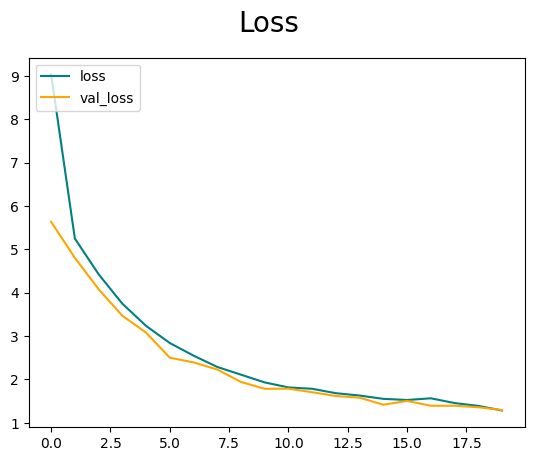

In [19]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

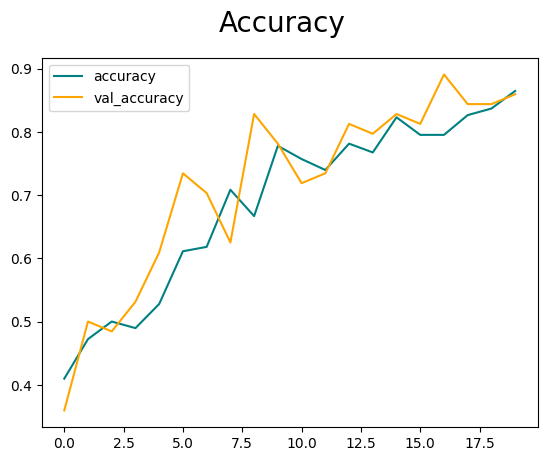

In [20]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()



In [21]:
model.save('Image_classification_model')


INFO:tensorflow:Assets written to: Image_classification_model\assets


INFO:tensorflow:Assets written to: Image_classification_model\assets


In [22]:
from tensorflow.keras.metrics import Precision, Recall, categorical_accuracy

p = Precision()
r = Recall()


In [23]:
for batch in test_data.as_numpy_iterator():
    X, Y = batch
    y_predicted = model.predict(X)
    p.update_state(Y, y_predicted)
    r.update_state(Y, y_predicted)
    
    

1/1 [==============================] - 3s 3s/step


In [24]:
print(p.result(), r.result())

tf.Tensor(0.82758623, shape=(), dtype=float32) tf.Tensor(0.75, shape=(), dtype=float32)


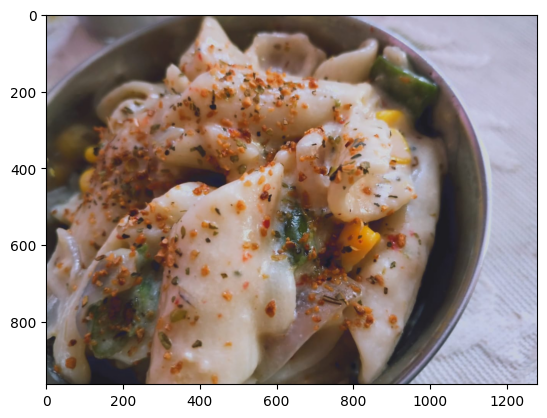

In [25]:
import cv2
from tensorflow.keras.preprocessing import image
img = cv2.imread('test_image0.jpg')
img_bgr = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_bgr)
plt.show()


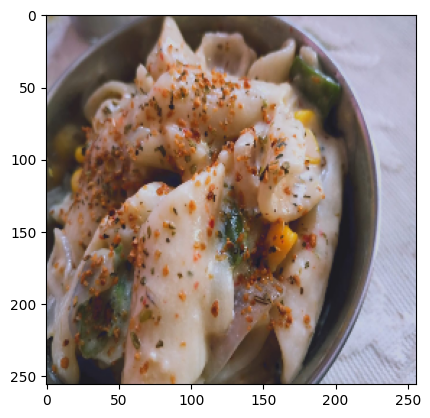

In [26]:
resize = tf.image.resize(img_bgr, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [30]:
def process_image(path):
    img_path = path  
    img = image.load_img(img_path, target_size=(256,256)) 
    img_array = image.img_to_array(img)  
    img_array = np.array(img_array, copy=True)  
    img_array = np.expand_dims(img_array, axis=0)  
    img_array /= 255.0  
    return img_array

predictions = model.predict(process_image('test_image0.jpg'))

predicted_class = np.argmax(predictions, axis=1) 
predicted_class_index = predicted_class[0]  
class_names = get_class_names(folder_path)
print("Predicted class:", class_names[predicted_class_index])

1/1 [==============================] - 0s 181ms/step
Predicted class: fettuccine alfredo
